# Objective

The main objective of this exercise is to find out how many people live in informal settlements, or so-called 'slums', in the Dakar metropolitan area in Senegal. To solve this, you will make use of different operations you have learned in this week's and previous lectures and exercises. Do not forget to take a look at the hints for this exercise!

## Data Description

- **Census Shapefile for Dakar (Level 4 Administrative Level for 2012) `[census.shp]`**: This layer contains 2 main columns:
  - `Department`: Refers to a coarser administrative level (Level 3).
  - `POPULATION`: Describes the total population at each of the polygon units.

- **Informal Settlements Shapefile `[informal_nb]`**: A shapefile of the informal settlements in the Dakar metropolitan area.

- **Population Polygon Grid**: At roughly 100-meter resolution. It contains a column named `VALUE` that records the population of each cell.

## Let's Start!



# Initial Steps

First of all, load the 3 layers as Geopandas data frames and give them appropriate names:

1. **Census Data**: Load the census shapefile for Dakar  as a Geopandas DataFrame. Consider naming it `df_census` for clarity.

2. **Informal Settlements**: Load the shapefile of the informal settlements in the Dakar metropolitan area into a Geopandas DataFrame. A suggested name could be `df_informal_settlements`.

3. **Population Grid**: Load the population polygon grid, which is at roughly 100-meter resolution, into a Geopandas DataFrame. You might name it `df_population_grid`.

After loading these layers, proceed with the analysis as instructed.


In [26]:
###importing everything that is necessary
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

##loading/reading the files into a variable
df_census = gpd.read_file("census.shp")
df_informal_settlements = gpd.read_file("informal_nb.shp")
df_population_grid = gpd.read_file("pop_grid_clip.shp").to_crs("EPSG:32628") ## only one that wasnt epsg 32628 so converted for consistency

# Task 1: Dissolve the Census Layer

## Objective

The goal of this task is to dissolve the census layer into a coarser administrative level (Level 3).

### Step 1: Visualize the Population

- **Plot the Census**: Visualize the `POPULATION` column by plotting the census layer. Consider adding a legend as well. This step will help in understanding the distribution of the population across the Dakar metropolitan area.

- **Optional**: You can consider computing the population density as well as it can be more informative to visualise.


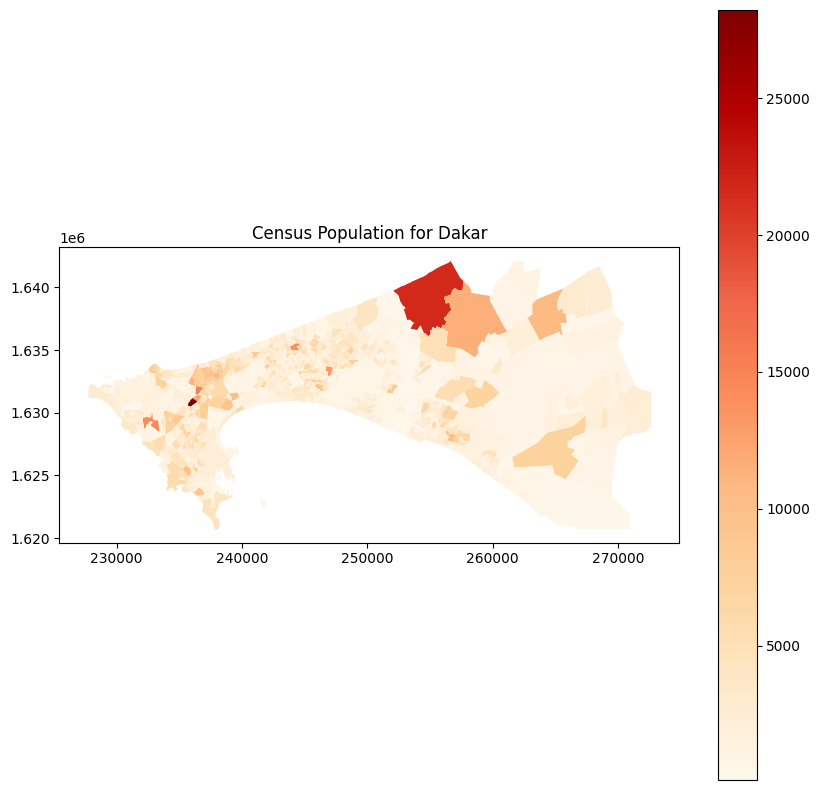

In [27]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10)) #set up a single subplot on a 10x10 inch canvas
df_census.plot(column="POPULATION", ax=axes, legend=True, cmap="OrRd") #plotting the population data with a legend and colour scheme from orange to red
axes.set_title("Census Population for Dakar") #title
plt.show() #show it

### Step 2: Dissolve the Census Layer by Department

- **Dissolve Operation**: Use the `Department` column to dissolve the census layer. Aggregate the data by summing up the values in the `POPULATION` column to get the total population for each Department.

- **Reset the Index**: After the dissolve operation, reset the index so that the `Department` becomes a column again. This is important for maintaining the structure of your DataFrame for further analysis.



In [28]:
###combine all features by dept, sum of pop, and reset index
df_census_dissolved = df_census.dissolve(by="Department", aggfunc={"POPULATION": "sum"}).reset_index()

### Step 3: Plot the Dissolved Census Layer

- Plot the dissolved census layer, using the `POPULATION` column. Ensure that your plot includes a legend to represent the population distribution across different departments effectively.

- Again optionally, you can compute and also visualize the population density instead.

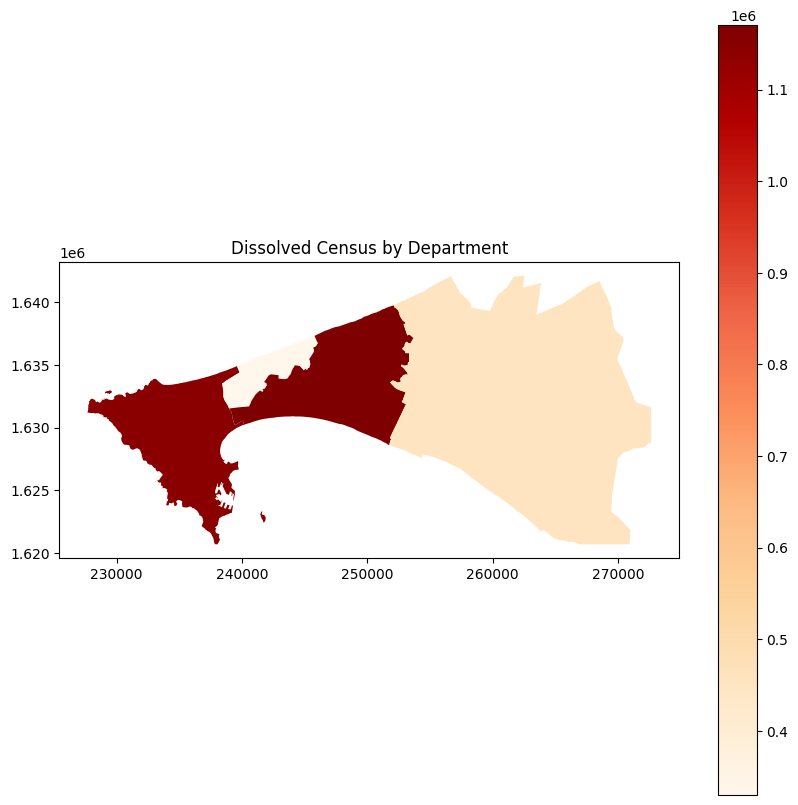


Answer to the question:
   Department  POPULATION
0       DAKAR     1146067
1  GUEDIAWAYE      330016
2      PIKINE     1170620
3    RUFISQUE      456980


In [29]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))#set up a single subplot on a 10x10 inch canvas
df_census_dissolved.plot(column="POPULATION", ax=axes, legend=True, cmap="OrRd")#plotting the population data with a legend and colour scheme from orange to red
axes.set_title("Dissolved Census by Department")#title
plt.show()#show it

#population of each Department in Dakar Metropolitan area
print("\nAnswer to the question:")
print(df_census_dissolved[["Department", "POPULATION"]])

Question: What is the population of each Department in Dakar Metropolitan area?

# Task 2: Population in Informal Settlements by Department

## Objective

The goal of this task is to determine the total population living in informal settlements within each Department in Dakar.

### Step 1: Intersect Informal Settlements with the Dissolved Census Layer

- **Intersection Operation**: Perform an intersection between the informal settlements layer and the dissolved census layer. This operation will help identify the parts of the census polygons that overlap with informal settlements.
-  **Visualize** the intersected layer using the 'Department Column'



In [30]:
#get overlapping parts of dissolved census and the informal settlements
df_intersect = gpd.overlay(df_census_dissolved, df_informal_settlements, how="intersection")

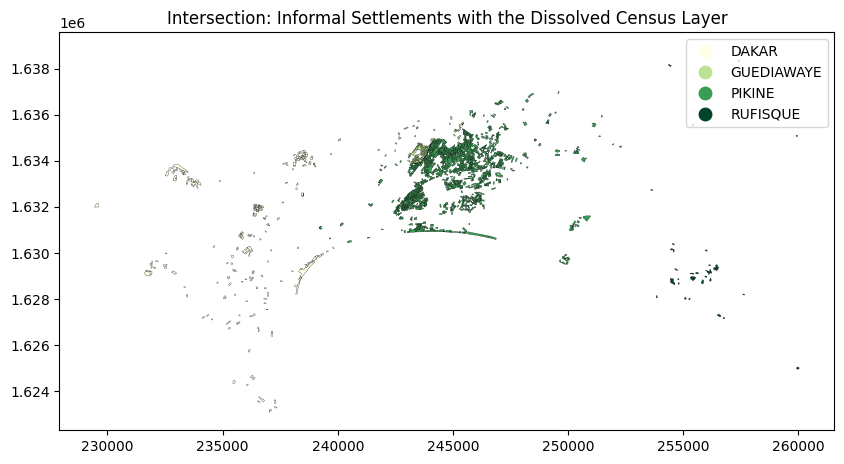

In [31]:
fig, axes = plt.subplots(figsize=(10, 8))#create plot area thats 10x8 inches
df_intersect.plot(column="Department", legend=True, cmap="YlGn", linewidth=0.2, edgecolor="black", ax=axes) #plot intersected data, color by dept using yellow to green colour scheme, with a legend
axes.set_title("Intersection: Informal Settlements with the Dissolved Census Layer")#title
plt.show()##show it

### Step 2: Spatial Join with the Population Grid

- **Spatial Join**: Perform a spatial join between the layer resulting from the intersection and the population grid layer. This join will allow you to attribute the population data from the grid to the corresponding areas of informal settlements.

- **Coordinate Reference System (CRS) Check**: Before performing the spatial join, ensure both layers are in the same CRS. If they are not, reproject one of the layers to match the CRS of the other.



In [32]:
df_joined = gpd.sjoin(df_population_grid, df_intersect[["Department", "geometry"]], how="inner", predicate="within") #join grid to intersected areas...keep only cells fully inside each department's area

Now plot your new layer after the spatial join using the 'VALUE' column and a legend. If it seems to be working, now you can see the distribution of the population of the informal settlements across Dakar!

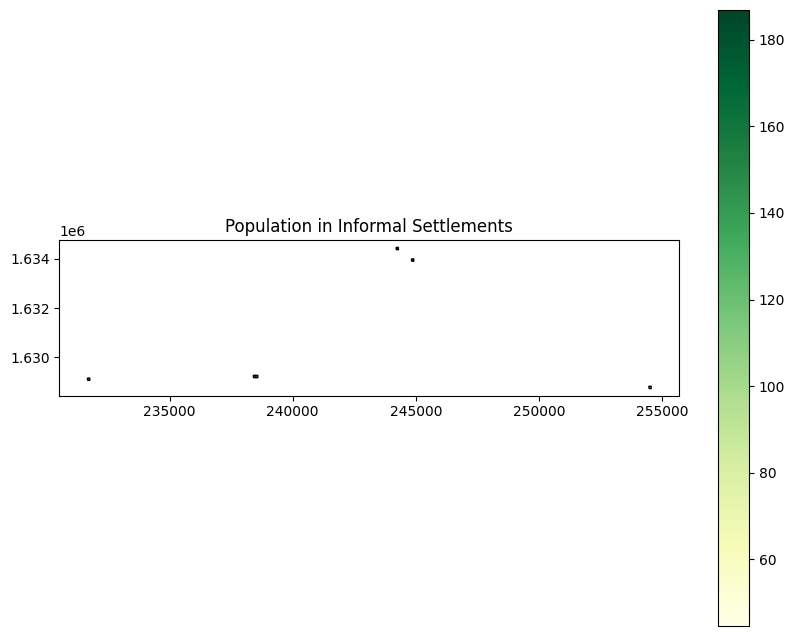

In [33]:
fig, axes = plt.subplots(figsize=(10, 8)) #create plot area thats 10x8 inches
df_joined.plot(column="VALUE", legend=True, cmap="YlGn", edgecolor="black", ax=axes) #plot the value data with a legend
axes.set_title("Population in Informal Settlements")#title
plt.show()#show it

### Step 3: Aggregate Population Data by Department

- **Group and Summarize**: After the spatial join, group the resulting data by the `Department` column. Summarize the `VALUE` column, which represents the population in each grid cell, to calculate the total population living in informal settlements for each Department.

- **New DataFrame Creation**: Create a new DataFrame from this grouped data. This new DataFrame should contain columns for each Department and their corresponding population on informal settlements.



In [34]:
pop_by_dept = df_joined.groupby("Department")["VALUE"].sum().reset_index() #group by department, sum population values, reset index

### Step 4: Merge Informal Population Data with Dissolved Census Layer

- **Merge Data**: Use the `merge` function to combine the new DataFrame containing the total population in informal settlements per Department with the previously dissolved census layer. The merge should be based on the `Department` column, which is common to both datasets.

- **Ensure Consistency**: Before merging, ensure that the `Department` column names and data types are consistent across both DataFrames to avoid any merging issues.

This final step integrates the detailed population analysis back into the broader census context, providing a comprehensive view of the population distribution, both in general and within informal settlements, across the Dakar metropolitan area's departments.


In [35]:
df_merged = df_census_dissolved.merge(pop_by_dept, on="Department", how="left") #merge dissolved census with population data by dept
df_merged["VALUE"] = df_merged["VALUE"].fillna(0) #replace missing population values with 0


- What is the proportion of people living in informal settlements per Department in comparison to the total population?
- Classify the proportion in a new column into 2 or 3 classes (for instance low, medium, high), according to your preference.
- Optional: Plot a map with the new classes
-  Make sure your code is well commented

In [36]:
df_merged["proportion"] = df_merged["VALUE"] / df_merged["POPULATION"] #compute fraction of population in slums vs total population per dept

#function that takes a proportion and classifies it low medium or high
def classify_proportion(prop):
    if prop < 0.1:
        return "low"
    elif prop < 0.3:
        return "medium"
    else:
        return "high"
df_merged["proportion_class"] = df_merged["proportion"].apply(classify_proportion) #labelling each dept
print("Final Merged Data with Proportions:")
print(df_merged[["Department", "POPULATION", "VALUE", "proportion", "proportion_class"]]) #results


Final Merged Data with Proportions:
   Department  POPULATION       VALUE  proportion proportion_class
0       DAKAR     1146067  415.063873    0.000362              low
1  GUEDIAWAYE      330016    0.000000    0.000000              low
2      PIKINE     1170620  344.291260    0.000294              low
3    RUFISQUE      456980   44.616470    0.000098              low
